In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from imblearn.over_sampling import RandomOverSampler

In [2]:
data = pd.read_csv("../data/clean/churn_modelling_clean.csv")
data.head()

,customer_id,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### Let's drop the column `customer_id`

In [3]:
data = data.drop("customer_id", axis=1)

#### Check for imbalance in the target variable

In [4]:
data['exited'].value_counts()

exited
0    7963
1    2037
Name: count, dtype: int64

Our target variable is highly imbalance, so we will apply oversampling later...

#### Take a look at the correlation matrix

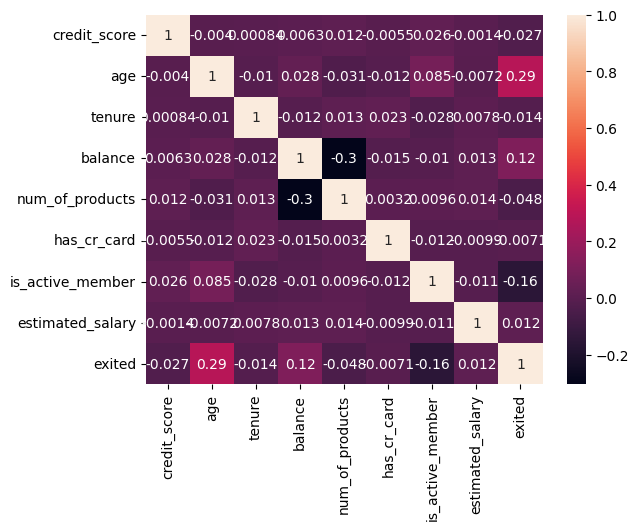

In [5]:
corr = data.select_dtypes(np.number).corr()
sns.heatmap(corr, annot=True)
plt.show()

As we can see, there are no linear relationships :-(

#### Do the X/y split

In [6]:
X = data.drop("exited", axis=1)
y = data["exited"]

#### Do the train/test split

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Split train and test set into numerical and categorical features

In [8]:
X_train_num = X_train.select_dtypes(np.number)
X_test_num = X_test.select_dtypes(np.number)

X_train_cat = X_train.select_dtypes(object)
X_test_cat = X_test.select_dtypes(object)

#### Scale numerical features

In [9]:
stdScaler = StandardScaler()
stdScaler.fit(X_train_num)

# Store scaler to pickle file
with open("../scaler/stdscaler.pickle", "wb") as file:
    pickle.dump(stdScaler, file)


X_train_num_scaled = stdScaler.transform(X_train_num)
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns)

X_test_num_scaled = stdScaler.transform(X_test_num)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns)

#### Encode categorical columns

In [10]:
onehotEncoder = OneHotEncoder(drop="first")
onehotEncoder.fit(X_train_cat)

# Store encoder to pickle file
with open("../encoders/onehot.pickle", "wb") as file:
    pickle.dump(onehotEncoder, file)

X_train_cat_encoded = onehotEncoder.transform(X_train_cat).toarray()
X_train_cat_encoded = pd.DataFrame(X_train_cat_encoded, columns=onehotEncoder.get_feature_names_out())

X_test_cat_encoded = onehotEncoder.transform(X_test_cat).toarray()
X_test_cat_encoded = pd.DataFrame(X_test_cat_encoded, columns=onehotEncoder.get_feature_names_out())

#### Build final train/test datasets

In [11]:
X_train_final = pd.concat([X_train_num_scaled, X_train_cat_encoded], axis=1)
X_test_final  = pd.concat([X_test_num_scaled, X_test_cat_encoded], axis=1)

#### Apply RandomOverSampler on the train set, since our target variable is highly imbalanced

In [12]:
overSampler = RandomOverSampler(random_state=1337)

print(f'Before oversampling:\n{y_train.value_counts()}\n')
X_train_final, y_train = overSampler.fit_resample(X_train_final, y_train)
print(f'After oversampling:\n{y_train.value_counts()}')

Before oversampling:
exited
0    6356
1    1644
Name: count, dtype: int64

After oversampling:
exited
0    6356
1    6356
Name: count, dtype: int64


In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score

def print_classification_results(y, y_pred, labels=[1,0]):
    '''
    Show classification results.
    This will create a plot with the confusion matrix and another one
    showing the precision against the recall and print the classification
    report.
    '''    
    fig,ax = plt.subplots(1,2, figsize=(9,3))

    cm = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=labels).plot(ax=ax[0])

    precisions, recalls, thresholds = precision_recall_curve(y, y_pred)
    ax[1].plot(thresholds, precisions[:-1], "b--", label="Precision")
    ax[1].plot(thresholds, recalls[:-1], "g-", label="Recall")
    ax[1].grid()
    ax[1].legend()

    plt.tight_layout()
    plt.show()
    print(classification_report(y, y_pred))
    print("cohen-kappa-score: {}".format(cohen_kappa_score(y, y_pred)))
    print()

### LogisticRegression

#### Best parameters:
<pre>
 {
    'multi_class': 'multinomial',
    'penalty': 'l2',
    'random_state': 42,
    'solver': 'newton-cg'
 }
</pre>

In [14]:
params = {
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'random_state': [42],
    'multi_class': ['multinomial', 'auto', 'ovr'],
    'penalty': ['l2', None]
}

In [15]:
gs = GridSearchCV(estimator=LogisticRegression(), param_grid=params, cv=5)
gs.fit(X_train_final, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'multi_class': ['multinomial', 'auto', 'ovr'],
                         'penalty': ['l2', None], 'random_state': [42],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']})

In [16]:
logReg = gs.best_estimator_

# Save the logistic model into the "models/" with pickle
with open("../models/logreg.pickle", "wb") as file:
    pickle.dump(logReg, file)

In [17]:
y_train_pred_logReg = logReg.predict(X_train_final)
y_test_pred_logReg  = logReg.predict(X_test_final)

LogisticRegression / Train set


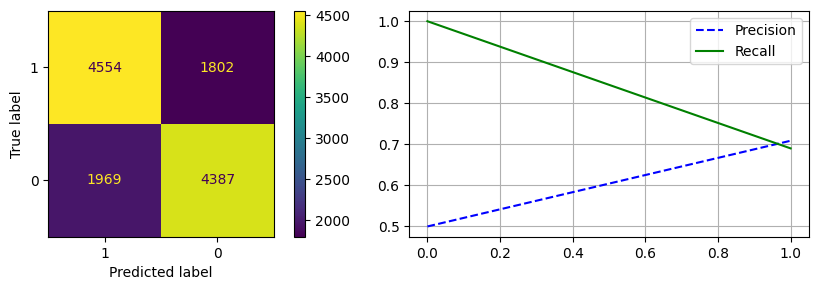

              precision    recall  f1-score   support

           0       0.70      0.72      0.71      6356
           1       0.71      0.69      0.70      6356

    accuracy                           0.70     12712
   macro avg       0.70      0.70      0.70     12712
weighted avg       0.70      0.70      0.70     12712

cohen-kappa-score: 0.40670232850849586


LogisticRegression / Test set


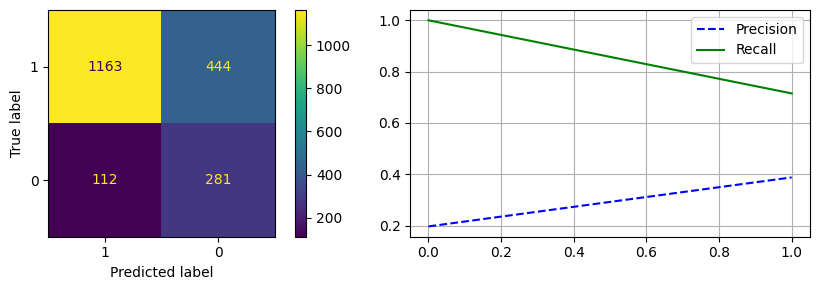

              precision    recall  f1-score   support

           0       0.91      0.72      0.81      1607
           1       0.39      0.72      0.50       393

    accuracy                           0.72      2000
   macro avg       0.65      0.72      0.65      2000
weighted avg       0.81      0.72      0.75      2000

cohen-kappa-score: 0.3325931038621973



In [18]:
print("LogisticRegression / Train set")
print_classification_results(y_train, y_train_pred_logReg)
print("\nLogisticRegression / Test set")
print_classification_results(y_test, y_test_pred_logReg)

### KNeighborsClassifier

#### Best parameters:
<pre>
 {
    'algorithm': 'auto',
    'n_neighbors': 10,
    'weights': 'distance'
 }
</pre>

In [19]:
params = {
    'n_neighbors': [3, 5, 8, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

In [20]:
gs = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params, cv=5)
gs.fit(X_train_final, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 8, 10],
                         'weights': ['uniform', 'distance']})

In [21]:
knn = gs.best_estimator_

# Save the model with pickle on the "models/" folder
with open("../models/knn.pickle", "wb") as file:
    pickle.dump(knn, file)

In [22]:
y_train_pred_knn = knn.predict(X_train_final)
y_test_pred_knn  = knn.predict(X_test_final)

KNeighborsClassifier / Train set


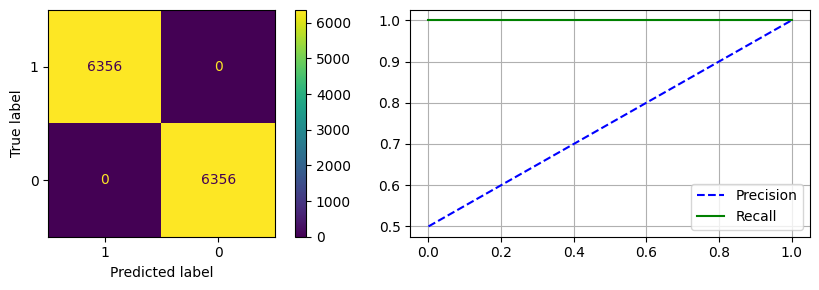

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6356
           1       1.00      1.00      1.00      6356

    accuracy                           1.00     12712
   macro avg       1.00      1.00      1.00     12712
weighted avg       1.00      1.00      1.00     12712

cohen-kappa-score: 1.0


KNeighborsClassifier / Test set


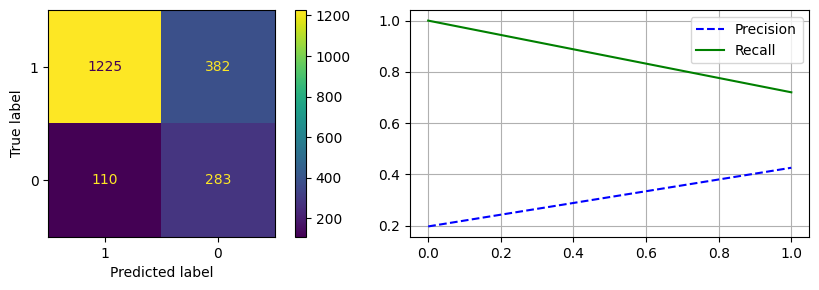

              precision    recall  f1-score   support

           0       0.92      0.76      0.83      1607
           1       0.43      0.72      0.53       393

    accuracy                           0.75      2000
   macro avg       0.67      0.74      0.68      2000
weighted avg       0.82      0.75      0.77      2000

cohen-kappa-score: 0.3824177341509185



In [23]:
print("KNeighborsClassifier / Train set")
print_classification_results(y_train, y_train_pred_knn)
print("\nKNeighborsClassifier / Test set")
print_classification_results(y_test, y_test_pred_knn)

<br>

### RandomForestClassifier

#### Best parameters:
<pre>
 {
    'criterion': 'log_loss',
    'min_samples_leaf': 2,
    'min_samples_split': 4
 }
</pre>

In [24]:
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_leaf': [2,4],
    'min_samples_split': [2,4]
}

In [25]:
gs = GridSearchCV(estimator=RandomForestClassifier(), param_grid=params, cv=5)
gs.fit(X_train_final, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'min_samples_leaf': [2, 4],
                         'min_samples_split': [2, 4]})

In [27]:
rndForest = gs.best_estimator_

# Save the model into the "models/" folder using pickle.
with open("../models/rndforest.pickle", "wb") as file:
    pickle.dump(rndForest, file)

In [28]:
y_train_pred_rndForest = rndForest.predict(X_train_final)
y_test_pred_rndForest  = rndForest.predict(X_test_final)

RandomForestClassifier / Train set


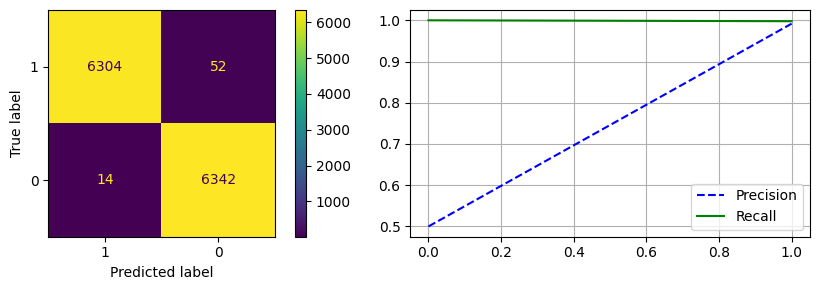

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      6356
           1       0.99      1.00      0.99      6356

    accuracy                           0.99     12712
   macro avg       0.99      0.99      0.99     12712
weighted avg       0.99      0.99      0.99     12712

cohen-kappa-score: 0.9896161107614853

\RandomForestClassifier / Test set


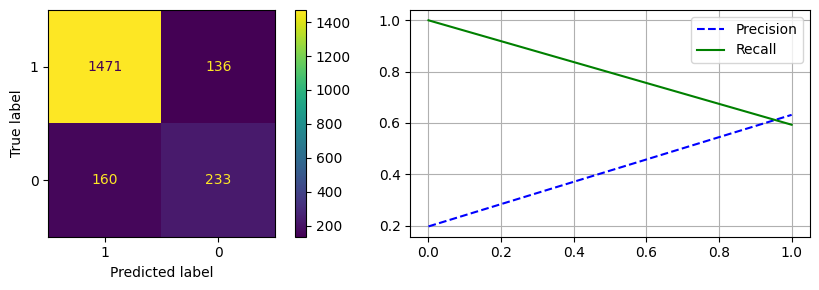

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1607
           1       0.63      0.59      0.61       393

    accuracy                           0.85      2000
   macro avg       0.77      0.75      0.76      2000
weighted avg       0.85      0.85      0.85      2000

cohen-kappa-score: 0.5202461007839763



In [29]:
print("RandomForestClassifier / Train set")
print_classification_results(y_train, y_train_pred_rndForest)
print("\RandomForestClassifier / Test set")
print_classification_results(y_test, y_test_pred_rndForest)

<br>

### Conclusion

Looking at the scores, the KNeighborRegressor is the best model with a cohen-kappa-score of 1.0 (!!!)